## Test class wrapper

In dycode we are able to define classes that contain objects with different implementations of the same method. This is useful when we want to introduce an experiment class that uses methods to run experiments, but each experiment might have different configurations. The most generic form of creating all these different configurations is to have a certain set of methods that are implemented differently per each of the instances.

In this notebook, we will briefly cover this functionality with a dummy example.

In [1]:
# Run the following for the notebook to work:
import sys
sys.path.append('..')

# autoreload for faster debug
%load_ext autoreload

### Use-Case: Generic Simulations

Now let's leverage the dynamic wrappers for running a physical simulation. We will show using this dummy example that a simulation can be implemented in the most generic case. For illustration, we will consider the throwing ball problem where we want to throw a ball on with an initial velocity and angle and check the trajectory that the ball takes in space. This can be simply done using the following set of forumalas in the ideal non-friction case:

* $x = v_0 \times t \sin(\theta)$
* $y = v_0 \times t \cos(\theta) - \frac{1}{2} g t^2$ where $g$ is the gravitational acceleration.

Now lets assume that we have wind blowing from $x = +\infty$ to $x = -\infty$ uniformly and horizontally inducing some acceleration on the ball denoted by $a_{wind}$, in that case the following formulas would carry out our simulation:

* $x = v_0 \times t \sin(\theta) - \frac{1}{2} a_{wind} t^2$
* $y = v_0 \times t \cos(\theta) - \frac{1}{2} g t^2$

For simplicity, we will assume that the acceleration induced by the windspeed has the following simple relation where $v_{wind}$ is the wind speed at a given time:
$$a_{wind} = v_{wind} \frac{s}{m}$$
 


In [2]:
%autoreload 2

import numpy as np
import typing as th
import matplotlib.pyplot as plt
from IPython.display import clear_output


class BallSimulator:
    """
    A simulator for throwing a ball with mass "m" and surface area "s" in the air from point (0, 0) 
    in the x-y plane with a given initial velocity and angle (v0, theta0).
    """
    
    def __init__(self, m: float, s: float, v0: float, theta0 : float, g : float = 9.81, v_wind: float = 3):
        self.m = m
        self.s = s
        self.g = g
        self.v0 = v0
        self.theta0 = theta0
        self.x = 0
        self.y = 0
        self.t = 0
        self.v_wind = v_wind
    
    def _real_simulation(self) -> th.List:
        sumlation = []

        gravity_acceleration = self.g
        wind_acceleration = self.v_wind * self.s / self.m
        
        while True:
            delta_t = 0.05
            
            self.x = self.v0 * self.t * np.cos(self.theta0) - 0.5 * self.t ** 2 * wind_acceleration
            self.y = self.v0 * self.t * np.sin(self.theta0) - 0.5 * self.t ** 2 * gravity_acceleration
            self.t += delta_t
            
            if self.y < 0:
                break
            sumlation.append((self.x, self.y))
        
        return sumlation
        
    def simulate(self):
        simulation_list = self._real_simulation()
        print(len(simulation_list))
        
        all_xs = [x for x, y in simulation_list]
        all_ys = [y for x, y in simulation_list]
        # get the maximum 'x' value in the simulation
        max_x = max(all_xs) + 1
        min_x = min(all_xs) - 1
        # get the maximum 'y' value in the simulation
        max_y = max(all_ys) + 1
        min_y = min(all_ys) - 0.25
        # create a matplotlib figure of size max_x and max_y
        for x, y in simulation_list:
            plt.plot(all_xs, all_ys, c='orange')
            # plot a line from (min_x, 0) to (max_x, 0)
            plt.plot([min_x, max_x], [min(all_ys), min(all_ys)], c='black')
            plt.scatter(x, y, c='b')
            plt.xlim(min_x, max_x)
            plt.ylim(min_y, max_y)
        
            plt.show()
            clear_output(wait=True)
        # close the figure
        plt.close()




Now run the following to see the ball in motion.

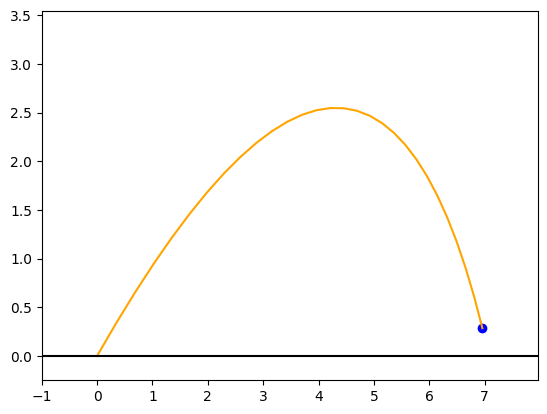

In [3]:
simul = BallSimulator(m=1, s=1, v0=10, theta0=np.pi/4, v_wind=3)
simul.simulate()

#### Method Wrappers

Now let's say you want to quickly consider the case where the wind speed changes according to time, in that case, the update function of the `x-axis` changes to the following:
* $\frac{d}{dt}x(t) = v_0 \sin(\theta) - t \times \frac{d}{dt} a_{wind}(t)$
The descritized formula for simulation would be as follows:
* $\Delta x(t) = v_0 \sin(\theta) - t \Delta a_{wind}(t) \times (\frac{1}{2} \Delta + t)$


One can for example write a scheduler and the `get_windspeed` function returns the current windspeed. Conventionally, for any type of scheduler, you should create a separate object and parametrize it and pass the parameters to the constructor of the simulation. However, this introduces the following issues:
1. A large constructor that takes in all the parameters of a simulation and reduces readability.
2. For any type of simulation with different schedulers you might need to create a separate class that inherits the simulator class.
With that in mind, one alternative to the second problem is to write down different scheduler functions in python and pass them as an argument so that a fully generic version of an instance is made. However, using the dynamic class decorators you can make this seamless and circumvent both of the issues mentioned.

In particular, we can create a simulator class as below with a tagged method `get_windspeed()`:

In [4]:
%autoreload 2

import numpy as np
import typing as th
import matplotlib.pyplot as plt
from IPython.display import clear_output

from dycode.wrappers import dynamize_methods, dynamic_method
%autoreload 2

this_is_a_global = 'global'


@dynamize_methods
class BallSimulator:
    """
    A simulator for throwing a ball with mass "m" and surface area "s" in the air from point (0, 0) 
    in the x-y plane with a given initial velocity and angle (v0, theta0).
    """
    
    def __init__(self, m: float, s: float, v0: float, theta0 : float, g : float = 9.81):
        self.m = m
        self.s = s
        self.g = g
        self.v0 = v0
        self.theta0 = theta0
        self.x = 0
        self.y = 0
        self.t = 0
    
    def _real_simulation(self) -> th.List:
        sumlation = [(0, 0)]

        gravity_acceleration = self.g
        
        while True:
            delta_t = 0.05
            
            wind_acceleration = self.get_windspeed() * self.s / self.m
            self.x += self.v0 * delta_t * np.cos(self.theta0) -  delta_t * wind_acceleration * (0.5 * delta_t + self.t)
            self.y = self.v0 * (self.t + delta_t) * np.sin(self.theta0) - 0.5 * (self.t + delta_t) ** 2 * gravity_acceleration
            self.t += delta_t

            sumlation.append((self.x, self.y))

            if self.y < 0:
                break
        
        return sumlation
        
    def simulate(self):
        simulation_list = self._real_simulation()
        
        all_xs = [x for x, y in simulation_list]
        all_ys = [y for x, y in simulation_list]
        # get the maximum 'x' value in the simulation
        max_x = max(all_xs) + 1
        min_x = min(all_xs) - 1
        # get the maximum 'y' value in the simulation
        max_y = max(all_ys) + 1
        min_y = min(all_ys) - 0.25
        # create a matplotlib figure of size max_x and max_y
        for x, y in simulation_list:
            plt.plot(all_xs, all_ys, c='orange')
            # plot a line from (min_x, 0) to (max_x, 0)
            plt.plot([min_x, max_x], [min(all_ys), min(all_ys)], c='black')
            plt.scatter(x, y, c='b')
            plt.xlim(min_x, max_x)
            plt.ylim(min_y, max_y)
        
            plt.show()
            clear_output(wait=True)
        # close the figure
        plt.close()
    
    @dynamic_method
    def get_windspeed(self):
        return 3




Now you can implement the dynamic function while constructing the simulator objects fast and efficiently. Hence, the code remains readable and at the same time generic.

In [5]:
# simulator where the windspeed is constant and equal to 3
simul1 = BallSimulator(1, 1, 10, 0.25 * np.pi)
# simulator where the windspeed is constant and equal to 5
simul2 = BallSimulator(1, 1, 10, 0.25 * np.pi, __dy__get_windspeed='lambda self: 5')
# simulator where the windspeed starts large but linearly decreases
simul3 = BallSimulator(1, 1, 10, 0.25 * np.pi, __dy__get_windspeed='lambda self: 10 - 5 * self.t')
# simulator with a fancy and generic scheduler
simul4 = BallSimulator(1, 1, 10, 0.25 * np.pi, __dy__get_windspeed='lambda self: 2 - self.t**2 if self.t < 1 else 5 * self.t')

Now run all of the simulators.

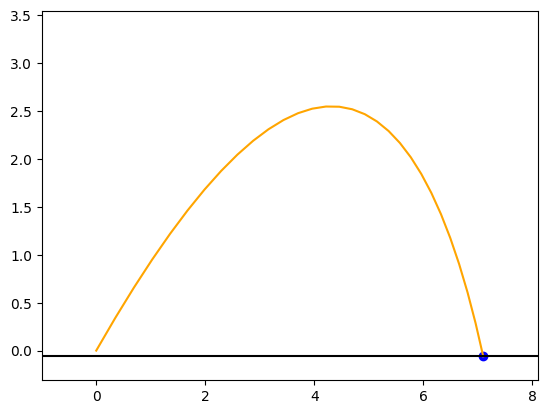

In [6]:

simul1.simulate()

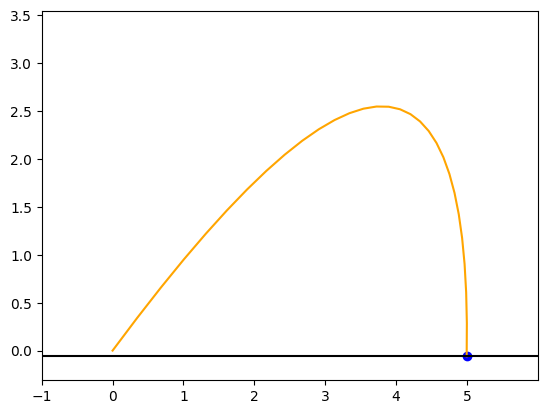

In [7]:
simul2.simulate()

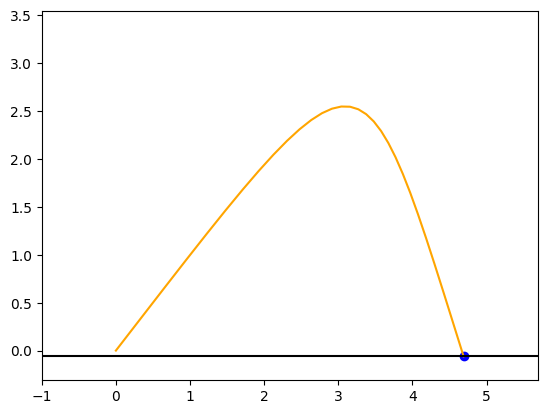

In [8]:
simul3.simulate()

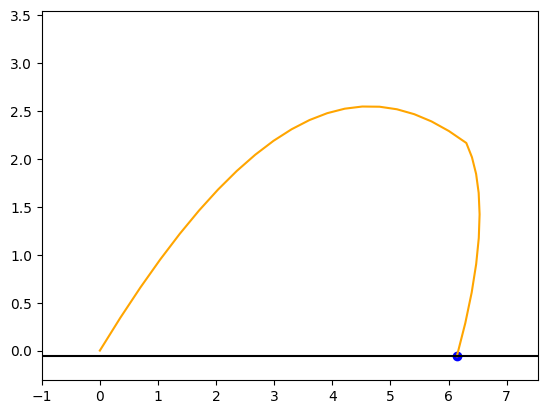

In [9]:
simul4.simulate()

The best part about this form of experiment is that since all the generic implementations can be written in `str` format which can be parsed, then one can create yaml files containing information regarding each and every one of the experiments. 

#### Field Wrappers

Now let's say we want to change a value such as `delta_t` and control it using the constructor. However, at the same time we don't want to fill up the constructor with extra values that will make the code unreadable. One alternative is to use a method `get_delta_t` and decorate it with the `@dynamic_method` tag introduced in the last section. However, a faster alternative is to use field wrappers, where we define a set of generic attributes we can control later on.

With that in mind, we use the `@dynamize_fields` decorator to define the generic field `delta_t` according to the following. We can also simplify the constructor for the default values.

In [10]:
%autoreload 2

import numpy as np
import typing as th
import matplotlib.pyplot as plt
from IPython.display import clear_output

from dycode.wrappers import dynamize_fields

@dynamize_fields
class BallSimulator:
    """
    A simulator for throwing a ball with mass "m" and surface area "s" in the air from point (0, 0) 
    in the x-y plane with a given initial velocity and angle (v0, theta0).
    """
    __dy__delta_t = 0.05
    __dy__g = 9.81
    __dy__v_wind = 3
    __dy__t = 0
    __dy__x = 0
    __dy__y = 0

    another_field : str = 'another field'

    def __init__(self, m: float, s: float, v0: float, theta0 : float):
        self.m = m
        self.s = s
        self.v0 = v0
        self.theta0 = theta0

    
    def _real_simulation(self) -> th.List:
        simulation = []

        gravity_acceleration = self.g
        wind_acceleration = self.v_wind * self.s / self.m
        
        simulation.append((0, 0))
        while True:
            # this changed into self.delta_t and calls the dynamic field in the class
            delta_t = self.delta_t
            
            self.x = self.v0 * self.t * np.cos(self.theta0) - 0.5 * self.t ** 2 * wind_acceleration
            self.y = self.v0 * self.t * np.sin(self.theta0) - 0.5 * self.t ** 2 * gravity_acceleration
            self.t += delta_t
            
            
            simulation.append((self.x, max(0, self.y)))

            if self.y < 0:
                break
        
        return simulation
        
    def simulate(self):
        simulation_list = self._real_simulation()
        
        all_xs = [x for x, y in simulation_list]
        all_ys = [y for x, y in simulation_list]
        # get the maximum 'x' value in the simulation
        max_x = max(all_xs) + 1
        min_x = min(all_xs) - 1
        # get the maximum 'y' value in the simulation
        max_y = max(all_ys) + 1
        min_y = min(all_ys) - 0.25
        # create a matplotlib figure of size max_x and max_y
        for x, y in simulation_list:
            plt.plot(all_xs, all_ys, c='orange')
            # plot a line from (min_x, 0) to (max_x, 0)
            plt.plot([min_x, max_x], [min(all_ys), min(all_ys)], c='black')
            plt.scatter(x, y, c='b')
            plt.xlim(min_x, max_x)
            plt.ylim(min_y, max_y)
        
            plt.show()
            clear_output(wait=True)
        # close the figure
        plt.close()





Now run the following simulator with a changed $\Delta$ value:

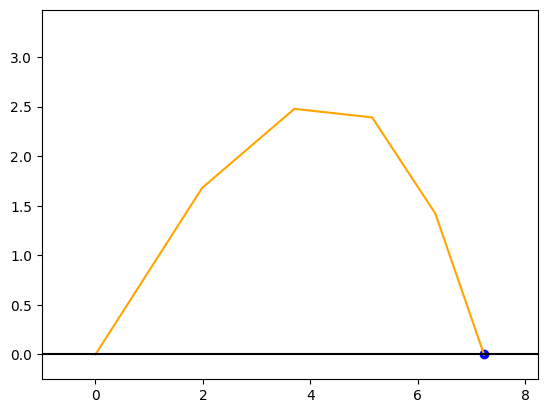

In [11]:
# This is a faster simulator with a non-smooth trajectory
simul = BallSimulator(1, 1, 10, 0.25 * np.pi, delta_t=0.3)

# show all the simul fields
simul.simulate()

#### All together

Finally, we can merge both wrappers using the `@dynamize` decorator defined below:

In [12]:
%autoreload 2
from dycode.wrappers import dynamize
import inspect
print(inspect.Signature.from_callable(dynamize))

(cls=None, /, *, indicator_prefix: Optional[str] = None, eval=False, blend=True)


In [20]:
%autoreload 2

import numpy as np
import typing as th
import matplotlib.pyplot as plt
from IPython.display import clear_output
from dycode.wrappers import dynamize, dynamic_method

@dynamize
class BallSimulator:
    """
    A simulator for throwing a ball with mass "m" and surface area "s" in the air from point (0, 0) 
    in the x-y plane with a given initial velocity and angle (v0, theta0).
    """
    __dy__delta_t = 0.05
    __dy__g = 9.81
    __dy__v_wind = 3
    __dy__t = 0
    __dy__x = 0
    __dy__y = 0

    another_field : str = 'another field'

    def __init__(self, m: float, s: float, v0: float, theta0 : float):
        self.m = m
        self.s = s
        self.v0 = v0
        self.theta0 = theta0

    
    def _real_simulation(self) -> th.List:
        simulation = []

        gravity_acceleration = self.g
        
        simulation.append((0, 0))
        while True:
            # this changed into self.delta_t and calls the dynamic field in the class
            delta_t = self.delta_t
            
            # get the dynamic windspeed from scheduler
            wind_acceleration = self.get_windspeed() * self.s / self.m
            
            self.x += self.v0 * delta_t * np.cos(self.theta0) -  delta_t * wind_acceleration * (0.5 * delta_t + self.t)
            self.y = self.v0 * (self.t + delta_t) * np.sin(self.theta0) - 0.5 * (self.t + delta_t) ** 2 * gravity_acceleration
            self.t += delta_t
            
            
            simulation.append((self.x, max(0, self.y)))

            if self.y < 0:
                break
        
        return simulation
        
    def simulate(self):
        simulation_list = self._real_simulation()
        
        all_xs = [x for x, y in simulation_list]
        all_ys = [y for x, y in simulation_list]
        # get the maximum 'x' value in the simulation
        max_x = max(all_xs) + 1
        min_x = min(all_xs) - 1
        # get the maximum 'y' value in the simulation
        max_y = max(all_ys) + 1
        min_y = min(all_ys) - 0.25
        # create a matplotlib figure of size max_x and max_y
        for x, y in simulation_list:
            plt.plot(all_xs, all_ys, c='orange')
            # plot a line from (min_x, 0) to (max_x, 0)
            plt.plot([min_x, max_x], [min(all_ys), min(all_ys)], c='black')
            plt.scatter(x, y, c='b')
            plt.xlim(min_x, max_x)
            plt.ylim(min_y, max_y)
        
            plt.show()
            clear_output(wait=True)
        # close the figure
        plt.close()
    
    @dynamic_method
    def get_windspeed(self):
        return self.v_wind





Final simulation for testing:

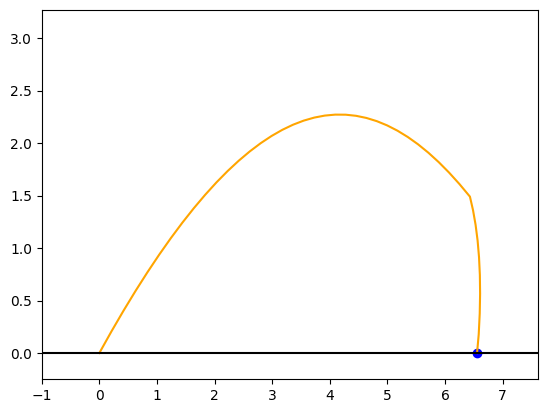

In [23]:
BallSimulator(1, 1, 10, 0.25 * np.pi, g=11, delta_t=0.03, __dy__get_windspeed='lambda self: 2 - self.t**2 if self.t < 1 else 5 * self.t').simulate()